In [1]:
import scanpy as sc
import numpy as np

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
adata=sc.read_h5ad("./data/t1d.h5ad")
print(adata)
print(adata.X[:10,:10])

AnnData object with n_obs × n_vars = 69645 × 26099
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'disease_state', 'cell_label', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'
  (0, 1)	1.076574683189392
  (3, 1)	0.6022599935531616
  (4, 1)	0.32389

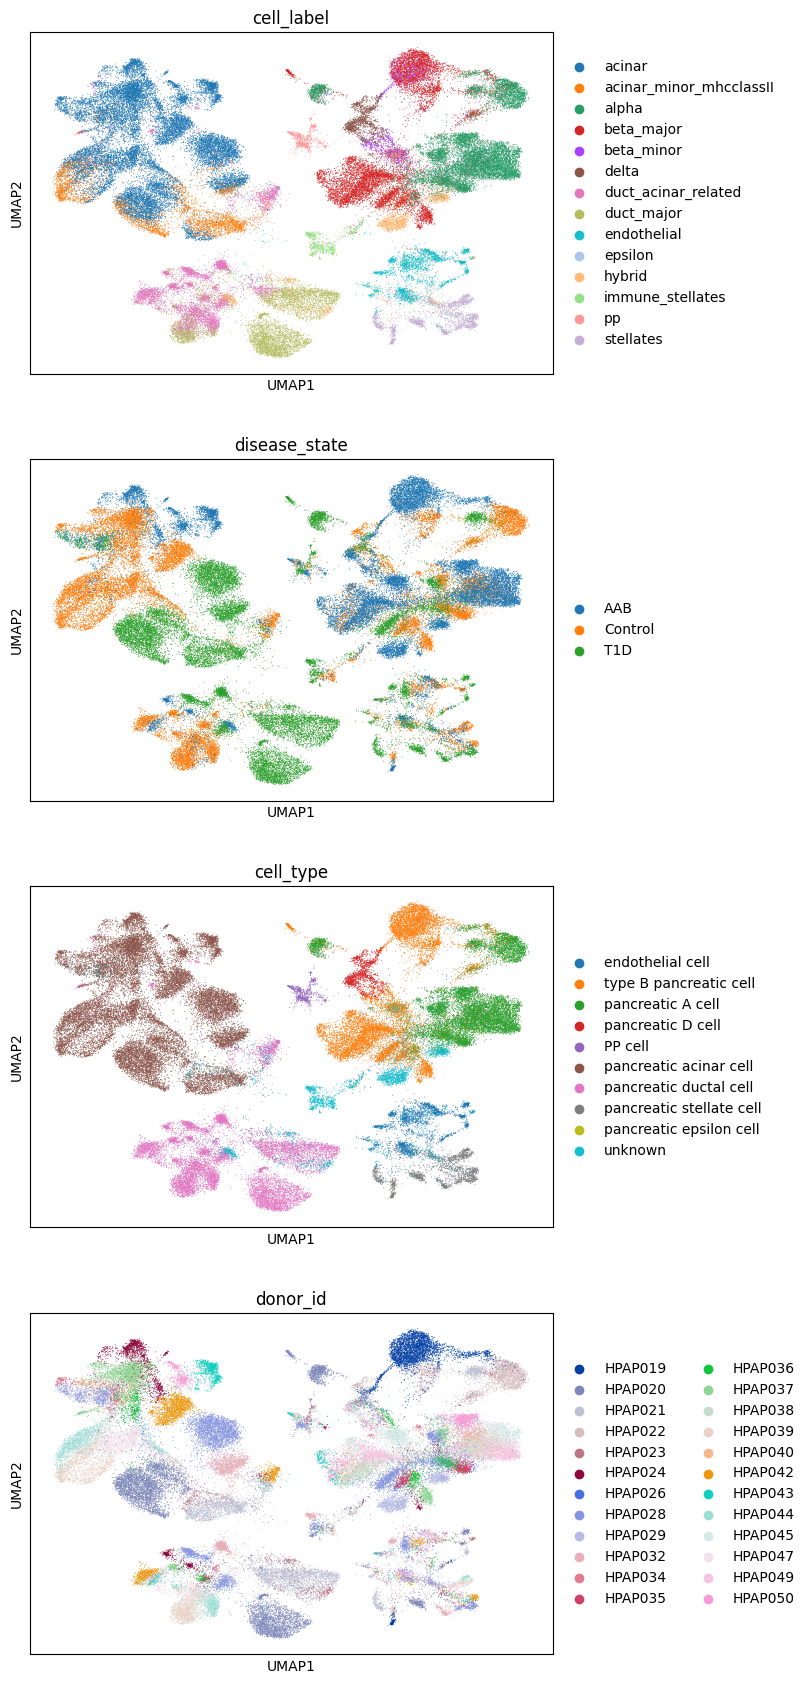

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id"],ncols=1)

# If we randomly permute the donor_id for each cell

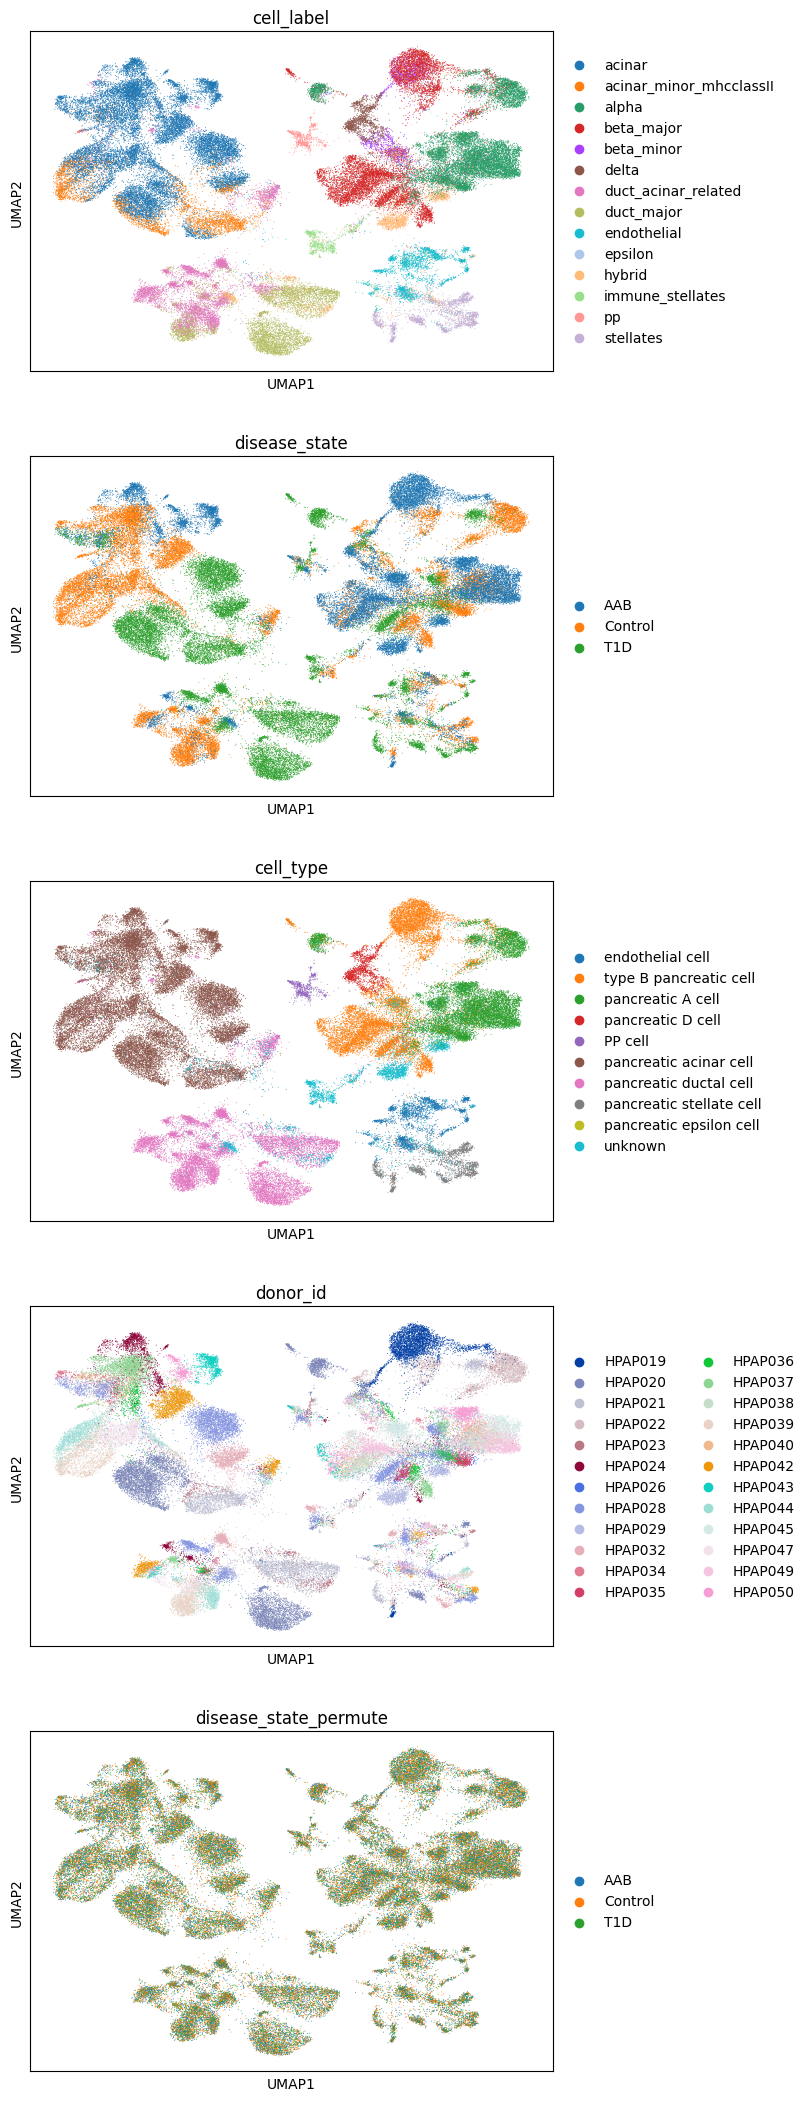

In [4]:
import pandas as pd
perm_indices = np.random.permutation(adata.obs.index)
df = pd.DataFrame(adata.obs[['disease_state']].copy())
df_permuted=df.loc[perm_indices, ['disease_state']].reset_index(drop=True)
adata.obs['disease_state_permute']=df_permuted.loc[:,'disease_state'].values
#adata.obs['donor_id_permute']=df_permuted.loc[:,'donor_id'].values
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id",'disease_state_permute'],ncols=1)

In [5]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="disease_state_permute", contorl_name='Control', num_hvg=2000, require_batch=True,
                            batch_key='donor_id',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=2048, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./t1d_fake_permute_condition/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./t1d_fake_permute_condition/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[donor_id] back up to adata.obs['batch_backup']
Original adata.obs[disease_state_permute] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'Control': 0, 'T1D': 1, 'AAB': 2}
Condition mapping to adata.obs['batch']: {'donor_id': {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18, 'HPAP020': 19, 'HPAP021': 20, 'HPAP023': 21, 'HPAP028': 22, 'HPAP032': 23}}
Unique batch mapping: {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18

Calculating the clusters
Unique groups: ['0_AAB' '0_Control' '0_T1D' '10_AAB' '10_Control' '10_T1D' '11_AAB'
 '11_Control' '11_T1D' '12_AAB' '12_Control' '12_T1D' '13_AAB'
 '13_Control' '13_T1D' '14_AAB' '14_Control' '14_T1D' '15_AAB'
 '15_Control' '15_T1D' '16_AAB' '16_Control' '16_T1D' '17_AAB'
 '17_Control' '17_T1D' '18_AAB' '18_Control' '18_T1D' '19_AAB'
 '19_Control' '19_T1D' '1_AAB' '1_Control' '1_T1D' '20_AAB' '20_Control'
 '20_T1D' '21_AAB' '21_Control' '21_T1D' '22_AAB' '22_Control' '22_T1D'
 '23_AAB' '23_Control' '23_T1D' '2_AAB' '2_Control' '2_T1D' '3_AAB'
 '3_Control' '3_T1D' '4_AAB' '4_Control' '4_T1D' '5_AAB' '5_Control'
 '5_T1D' '6_AAB' '6_Control' '6_T1D' '7_AAB' '7_Control' '7_T1D' '8_AAB'
 '8_Control' '8_T1D' '9_AAB' '9_Control' '9_T1D']
Mean number of cells in this dataset less than 2000, cluster using all cells instead of one group (unique batch and condition combination) by one group


Finished clustering
Data preprocessing done


Remaining number of cells: 69645
Require batch: True
Batch name to number mapping (may be used for search for saved adata):
 {'donor_id': {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18, 'HPAP020': 19, 'HPAP021': 20, 'HPAP023': 21, 'HPAP028': 22, 'HPAP032': 23}}
Condition name to number mapping (may be used for search for saved adata):
 {'Control': 0, 'T1D': 1, 'AAB': 2}
Preprocessing time: 129.52364 seconds


Overall Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Resetting 779 unused embeddings.
Resetting 790 unused embeddings.


Resetting 811 unused embeddings.
Resetting 763 unused embeddings.


Resetting 792 unused embeddings.
Resetting 792 unused embeddings.


Resetting 799 unused embeddings.
Resetting 803 unused embeddings.


Resetting 809 unused embeddings.
Resetting 780 unused embeddings.


Resetting 787 unused embeddings.
Resetting 764 unused embeddings.


Resetting 795 unused embeddings.
Resetting 776 unused embeddings.


Resetting 780 unused embeddings.


Resetting 798 unused embeddings.
Resetting 777 unused embeddings.


Resetting 825 unused embeddings.
Resetting 808 unused embeddings.


Resetting 840 unused embeddings.
Resetting 767 unused embeddings.


Resetting 802 unused embeddings.
Resetting 797 unused embeddings.


Resetting 804 unused embeddings.
Resetting 801 unused embeddings.


Resetting 793 unused embeddings.


Resetting 769 unused embeddings.
Resetting 784 unused embeddings.


Resetting 760 unused embeddings.
Resetting 797 unused embeddings.


Resetting 788 unused embeddings.
Resetting 772 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 0


Resetting 721 unused embeddings.
Resetting 688 unused embeddings.


Resetting 709 unused embeddings.
Resetting 665 unused embeddings.


Resetting 697 unused embeddings.
Resetting 716 unused embeddings.


Resetting 722 unused embeddings.
Resetting 740 unused embeddings.


Resetting 686 unused embeddings.
Resetting 687 unused embeddings.


Resetting 752 unused embeddings.
Resetting 647 unused embeddings.


Resetting 764 unused embeddings.
Resetting 688 unused embeddings.


Resetting 681 unused embeddings.
Resetting 804 unused embeddings.


Resetting 729 unused embeddings.
Resetting 723 unused embeddings.


Resetting 711 unused embeddings.
Resetting 712 unused embeddings.


Resetting 649 unused embeddings.
Resetting 797 unused embeddings.


Resetting 697 unused embeddings.
Resetting 805 unused embeddings.


Resetting 719 unused embeddings.
Resetting 671 unused embeddings.


Resetting 697 unused embeddings.
Resetting 643 unused embeddings.


Resetting 704 unused embeddings.
Resetting 654 unused embeddings.


Resetting 691 unused embeddings.
Resetting 706 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 0


Epoch: 1/10 | All Loss: 114.6203 | Neighborhood Loss: 56.8480 | Triplet Loss: 3.4805 | Reconstruction Loss: 6.5891 | Independent Loss: 53.4638 | KL Loss: 0.1840 | Commitment Loss: 0.3169 | Dependent Loss: -6.2620


Resetting 715 unused embeddings.
Resetting 672 unused embeddings.


Resetting 688 unused embeddings.
Resetting 607 unused embeddings.


Resetting 684 unused embeddings.
Resetting 702 unused embeddings.


Resetting 714 unused embeddings.
Resetting 704 unused embeddings.


Resetting 694 unused embeddings.
Resetting 671 unused embeddings.


Resetting 726 unused embeddings.
Resetting 649 unused embeddings.


Resetting 743 unused embeddings.
Resetting 675 unused embeddings.


Resetting 675 unused embeddings.
Resetting 735 unused embeddings.


Resetting 710 unused embeddings.
Resetting 714 unused embeddings.


Resetting 697 unused embeddings.
Resetting 690 unused embeddings.


Resetting 653 unused embeddings.
Resetting 773 unused embeddings.


Resetting 651 unused embeddings.
Resetting 783 unused embeddings.


Resetting 708 unused embeddings.


Resetting 665 unused embeddings.
Resetting 657 unused embeddings.


Resetting 624 unused embeddings.
Resetting 683 unused embeddings.


Resetting 658 unused embeddings.
Resetting 681 unused embeddings.


Resetting 674 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 1


Resetting 715 unused embeddings.
Resetting 661 unused embeddings.


Resetting 695 unused embeddings.
Resetting 605 unused embeddings.


Resetting 680 unused embeddings.
Resetting 708 unused embeddings.


Resetting 723 unused embeddings.
Resetting 692 unused embeddings.


Resetting 697 unused embeddings.
Resetting 666 unused embeddings.


Resetting 715 unused embeddings.
Resetting 657 unused embeddings.


Resetting 733 unused embeddings.
Resetting 682 unused embeddings.


Resetting 676 unused embeddings.
Resetting 723 unused embeddings.


Resetting 698 unused embeddings.
Resetting 720 unused embeddings.


Resetting 699 unused embeddings.
Resetting 666 unused embeddings.


Resetting 662 unused embeddings.
Resetting 763 unused embeddings.


Resetting 618 unused embeddings.
Resetting 777 unused embeddings.


Resetting 697 unused embeddings.
Resetting 660 unused embeddings.


Resetting 675 unused embeddings.
Resetting 641 unused embeddings.


Resetting 687 unused embeddings.
Resetting 648 unused embeddings.


Resetting 681 unused embeddings.
Resetting 685 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 1


Epoch: 2/10 | All Loss: 77.2761 | Neighborhood Loss: 52.3830 | Triplet Loss: 1.6790 | Reconstruction Loss: 5.0616 | Independent Loss: 22.4956 | KL Loss: 0.1003 | Commitment Loss: 0.1569 | Dependent Loss: -4.6004


Resetting 720 unused embeddings.
Resetting 670 unused embeddings.


Resetting 706 unused embeddings.
Resetting 618 unused embeddings.


Resetting 687 unused embeddings.
Resetting 720 unused embeddings.


Resetting 732 unused embeddings.
Resetting 700 unused embeddings.


Resetting 706 unused embeddings.
Resetting 675 unused embeddings.


Resetting 726 unused embeddings.
Resetting 664 unused embeddings.


Resetting 739 unused embeddings.
Resetting 693 unused embeddings.


Resetting 680 unused embeddings.
Resetting 730 unused embeddings.


Resetting 705 unused embeddings.
Resetting 724 unused embeddings.


Resetting 707 unused embeddings.
Resetting 674 unused embeddings.


Resetting 678 unused embeddings.
Resetting 754 unused embeddings.


Resetting 635 unused embeddings.
Resetting 779 unused embeddings.


Resetting 689 unused embeddings.
Resetting 676 unused embeddings.


Resetting 680 unused embeddings.
Resetting 654 unused embeddings.


Resetting 708 unused embeddings.
Resetting 648 unused embeddings.


Resetting 700 unused embeddings.


Resetting 695 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Resetting 730 unused embeddings.
Resetting 683 unused embeddings.


Resetting 708 unused embeddings.
Resetting 630 unused embeddings.


Resetting 694 unused embeddings.
Resetting 716 unused embeddings.


Resetting 741 unused embeddings.
Resetting 706 unused embeddings.


Resetting 710 unused embeddings.


Resetting 679 unused embeddings.


Resetting 736 unused embeddings.
Resetting 672 unused embeddings.


Resetting 737 unused embeddings.
Resetting 701 unused embeddings.


Resetting 688 unused embeddings.
Resetting 739 unused embeddings.


Resetting 713 unused embeddings.
Resetting 730 unused embeddings.


Resetting 709 unused embeddings.
Resetting 680 unused embeddings.


Resetting 684 unused embeddings.
Resetting 730 unused embeddings.


Resetting 645 unused embeddings.
Resetting 775 unused embeddings.


Resetting 698 unused embeddings.
Resetting 681 unused embeddings.


Resetting 686 unused embeddings.
Resetting 666 unused embeddings.


Resetting 719 unused embeddings.
Resetting 652 unused embeddings.


Resetting 708 unused embeddings.
Resetting 670 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Resetting 732 unused embeddings.
Resetting 681 unused embeddings.


Resetting 716 unused embeddings.
Resetting 633 unused embeddings.


Resetting 699 unused embeddings.
Resetting 705 unused embeddings.


Resetting 746 unused embeddings.
Resetting 716 unused embeddings.


Resetting 709 unused embeddings.
Resetting 695 unused embeddings.


Resetting 739 unused embeddings.
Resetting 682 unused embeddings.


Resetting 730 unused embeddings.
Resetting 699 unused embeddings.


Resetting 692 unused embeddings.
Resetting 743 unused embeddings.


Resetting 714 unused embeddings.
Resetting 732 unused embeddings.


Resetting 714 unused embeddings.
Resetting 684 unused embeddings.


Resetting 688 unused embeddings.
Resetting 720 unused embeddings.


Resetting 656 unused embeddings.


Resetting 776 unused embeddings.


Resetting 706 unused embeddings.


Resetting 686 unused embeddings.
Resetting 693 unused embeddings.


Resetting 671 unused embeddings.
Resetting 726 unused embeddings.


Resetting 650 unused embeddings.
Resetting 713 unused embeddings.


Resetting 668 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Epoch: 3/10 | All Loss: 70.2062 | Neighborhood Loss: 50.2227 | Triplet Loss: 1.5280 | Reconstruction Loss: 4.7208 | Independent Loss: 17.3021 | KL Loss: 0.0962 | Commitment Loss: 0.1523 | Dependent Loss: -3.8158


Resetting 735 unused embeddings.
Resetting 692 unused embeddings.


Resetting 721 unused embeddings.
Resetting 640 unused embeddings.


Resetting 711 unused embeddings.
Resetting 682 unused embeddings.


Resetting 749 unused embeddings.
Resetting 721 unused embeddings.


Resetting 717 unused embeddings.
Resetting 705 unused embeddings.


Resetting 754 unused embeddings.
Resetting 687 unused embeddings.


Resetting 737 unused embeddings.
Resetting 708 unused embeddings.


Resetting 681 unused embeddings.
Resetting 742 unused embeddings.


Resetting 714 unused embeddings.
Resetting 737 unused embeddings.


Resetting 719 unused embeddings.
Resetting 684 unused embeddings.


Resetting 696 unused embeddings.
Resetting 719 unused embeddings.


Resetting 666 unused embeddings.
Resetting 779 unused embeddings.


Resetting 707 unused embeddings.
Resetting 688 unused embeddings.


Resetting 697 unused embeddings.


Resetting 684 unused embeddings.
Resetting 731 unused embeddings.


Resetting 655 unused embeddings.
Resetting 716 unused embeddings.


Resetting 677 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 3


Resetting 738 unused embeddings.
Resetting 697 unused embeddings.


Resetting 727 unused embeddings.
Resetting 644 unused embeddings.


Resetting 718 unused embeddings.
Resetting 681 unused embeddings.


Resetting 755 unused embeddings.
Resetting 725 unused embeddings.


Resetting 721 unused embeddings.
Resetting 713 unused embeddings.


Resetting 760 unused embeddings.
Resetting 697 unused embeddings.


Resetting 736 unused embeddings.
Resetting 715 unused embeddings.


Resetting 691 unused embeddings.
Resetting 744 unused embeddings.


Resetting 716 unused embeddings.
Resetting 745 unused embeddings.


Resetting 723 unused embeddings.
Resetting 685 unused embeddings.


Resetting 705 unused embeddings.


Resetting 730 unused embeddings.
Resetting 674 unused embeddings.


Resetting 783 unused embeddings.


Resetting 714 unused embeddings.
Resetting 689 unused embeddings.


Resetting 706 unused embeddings.
Resetting 693 unused embeddings.


Resetting 738 unused embeddings.
Resetting 659 unused embeddings.


Resetting 722 unused embeddings.
Resetting 698 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 3


Epoch: 4/10 | All Loss: 68.3880 | Neighborhood Loss: 49.0050 | Triplet Loss: 1.5008 | Reconstruction Loss: 4.6343 | Independent Loss: 16.6732 | KL Loss: 0.1002 | Commitment Loss: 0.1566 | Dependent Loss: -3.6821


Resetting 742 unused embeddings.
Resetting 703 unused embeddings.


Resetting 735 unused embeddings.
Resetting 657 unused embeddings.


Resetting 725 unused embeddings.
Resetting 691 unused embeddings.


Resetting 756 unused embeddings.
Resetting 728 unused embeddings.


Resetting 728 unused embeddings.
Resetting 721 unused embeddings.


Resetting 766 unused embeddings.
Resetting 699 unused embeddings.


Resetting 733 unused embeddings.
Resetting 719 unused embeddings.


Resetting 695 unused embeddings.
Resetting 746 unused embeddings.


Resetting 721 unused embeddings.
Resetting 749 unused embeddings.


Resetting 727 unused embeddings.
Resetting 687 unused embeddings.


Resetting 711 unused embeddings.
Resetting 737 unused embeddings.


Resetting 681 unused embeddings.
Resetting 768 unused embeddings.


Resetting 724 unused embeddings.
Resetting 690 unused embeddings.


Resetting 716 unused embeddings.
Resetting 702 unused embeddings.


Resetting 746 unused embeddings.
Resetting 666 unused embeddings.


Resetting 728 unused embeddings.
Resetting 703 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4


Resetting 749 unused embeddings.
Resetting 707 unused embeddings.


Resetting 739 unused embeddings.
Resetting 664 unused embeddings.


Resetting 729 unused embeddings.
Resetting 697 unused embeddings.


Resetting 757 unused embeddings.
Resetting 730 unused embeddings.


Resetting 731 unused embeddings.
Resetting 724 unused embeddings.


Resetting 769 unused embeddings.
Resetting 702 unused embeddings.


Resetting 732 unused embeddings.
Resetting 723 unused embeddings.


Resetting 701 unused embeddings.
Resetting 749 unused embeddings.


Resetting 729 unused embeddings.
Resetting 758 unused embeddings.


Resetting 730 unused embeddings.


Resetting 687 unused embeddings.
Resetting 713 unused embeddings.


Resetting 741 unused embeddings.
Resetting 685 unused embeddings.


Resetting 772 unused embeddings.
Resetting 721 unused embeddings.


Resetting 692 unused embeddings.
Resetting 719 unused embeddings.


Resetting 708 unused embeddings.
Resetting 749 unused embeddings.


Resetting 673 unused embeddings.
Resetting 735 unused embeddings.


Resetting 710 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4


Resetting 752 unused embeddings.
Resetting 711 unused embeddings.


Resetting 744 unused embeddings.


Resetting 665 unused embeddings.
Resetting 737 unused embeddings.


Resetting 695 unused embeddings.
Resetting 759 unused embeddings.


Resetting 734 unused embeddings.
Resetting 732 unused embeddings.


Resetting 725 unused embeddings.
Resetting 772 unused embeddings.


Resetting 707 unused embeddings.


Resetting 734 unused embeddings.
Resetting 727 unused embeddings.


Resetting 709 unused embeddings.


Resetting 755 unused embeddings.
Resetting 734 unused embeddings.


Resetting 761 unused embeddings.
Resetting 730 unused embeddings.


Resetting 685 unused embeddings.
Resetting 719 unused embeddings.


Resetting 747 unused embeddings.
Resetting 691 unused embeddings.


Resetting 771 unused embeddings.
Resetting 721 unused embeddings.


Resetting 695 unused embeddings.
Resetting 720 unused embeddings.


Resetting 713 unused embeddings.
Resetting 755 unused embeddings.


Resetting 673 unused embeddings.
Resetting 737 unused embeddings.


Resetting 717 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4
Epoch: 5/10 | All Loss: 65.2779 | Neighborhood Loss: 46.2852 | Triplet Loss: 1.3890 | Reconstruction Loss: 4.4824 | Independent Loss: 17.0477 | KL Loss: 0.0994 | Commitment Loss: 0.1687 | Dependent Loss: -4.1944


Resetting 759 unused embeddings.
Resetting 714 unused embeddings.


Resetting 748 unused embeddings.
Resetting 669 unused embeddings.


Resetting 736 unused embeddings.
Resetting 705 unused embeddings.


Resetting 765 unused embeddings.
Resetting 737 unused embeddings.


Resetting 735 unused embeddings.
Resetting 725 unused embeddings.


Resetting 773 unused embeddings.
Resetting 712 unused embeddings.


Resetting 738 unused embeddings.
Resetting 736 unused embeddings.


Resetting 716 unused embeddings.
Resetting 758 unused embeddings.


Resetting 742 unused embeddings.
Resetting 764 unused embeddings.


Resetting 734 unused embeddings.
Resetting 686 unused embeddings.


Resetting 721 unused embeddings.
Resetting 750 unused embeddings.


Resetting 699 unused embeddings.
Resetting 770 unused embeddings.


Resetting 725 unused embeddings.
Resetting 696 unused embeddings.


Resetting 727 unused embeddings.
Resetting 713 unused embeddings.


Resetting 760 unused embeddings.
Resetting 677 unused embeddings.


Resetting 743 unused embeddings.
Resetting 722 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 5


Resetting 763 unused embeddings.
Resetting 721 unused embeddings.


Resetting 749 unused embeddings.


Resetting 672 unused embeddings.


Resetting 737 unused embeddings.


Resetting 707 unused embeddings.


Resetting 770 unused embeddings.
Resetting 735 unused embeddings.


Resetting 739 unused embeddings.
Resetting 728 unused embeddings.


Resetting 774 unused embeddings.
Resetting 718 unused embeddings.


Resetting 739 unused embeddings.
Resetting 736 unused embeddings.


Resetting 717 unused embeddings.
Resetting 763 unused embeddings.


Resetting 744 unused embeddings.
Resetting 768 unused embeddings.


Resetting 735 unused embeddings.
Resetting 687 unused embeddings.


Resetting 724 unused embeddings.


Resetting 756 unused embeddings.
Resetting 704 unused embeddings.


Resetting 770 unused embeddings.
Resetting 728 unused embeddings.


Resetting 696 unused embeddings.
Resetting 732 unused embeddings.


Resetting 717 unused embeddings.
Resetting 762 unused embeddings.


Resetting 681 unused embeddings.
Resetting 746 unused embeddings.


Resetting 732 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 5


Epoch: 6/10 | All Loss: 64.8220 | Neighborhood Loss: 46.2093 | Triplet Loss: 1.4501 | Reconstruction Loss: 4.4744 | Independent Loss: 16.3313 | KL Loss: 0.1023 | Commitment Loss: 0.1694 | Dependent Loss: -3.9148


Resetting 778 unused embeddings.
Resetting 728 unused embeddings.


Resetting 749 unused embeddings.
Resetting 674 unused embeddings.


Resetting 739 unused embeddings.
Resetting 712 unused embeddings.


Resetting 772 unused embeddings.
Resetting 739 unused embeddings.


Resetting 740 unused embeddings.
Resetting 734 unused embeddings.


Resetting 775 unused embeddings.
Resetting 722 unused embeddings.


Resetting 744 unused embeddings.
Resetting 740 unused embeddings.


Resetting 722 unused embeddings.
Resetting 768 unused embeddings.


Resetting 741 unused embeddings.
Resetting 770 unused embeddings.


Resetting 744 unused embeddings.
Resetting 689 unused embeddings.


Resetting 730 unused embeddings.
Resetting 763 unused embeddings.


Resetting 707 unused embeddings.
Resetting 777 unused embeddings.


Resetting 735 unused embeddings.
Resetting 696 unused embeddings.


Resetting 740 unused embeddings.
Resetting 721 unused embeddings.


Resetting 764 unused embeddings.
Resetting 683 unused embeddings.


Resetting 750 unused embeddings.
Resetting 734 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 6


Resetting 781 unused embeddings.


Resetting 736 unused embeddings.


Resetting 751 unused embeddings.
Resetting 677 unused embeddings.


Resetting 744 unused embeddings.
Resetting 716 unused embeddings.


Resetting 778 unused embeddings.
Resetting 743 unused embeddings.


Resetting 744 unused embeddings.
Resetting 739 unused embeddings.


Resetting 780 unused embeddings.
Resetting 727 unused embeddings.


Resetting 744 unused embeddings.
Resetting 742 unused embeddings.


Resetting 726 unused embeddings.
Resetting 769 unused embeddings.


Resetting 748 unused embeddings.
Resetting 773 unused embeddings.


Resetting 748 unused embeddings.
Resetting 693 unused embeddings.


Resetting 734 unused embeddings.
Resetting 765 unused embeddings.


Resetting 709 unused embeddings.
Resetting 774 unused embeddings.


Resetting 738 unused embeddings.
Resetting 700 unused embeddings.


Resetting 740 unused embeddings.


Resetting 724 unused embeddings.
Resetting 769 unused embeddings.


Resetting 685 unused embeddings.


Resetting 749 unused embeddings.
Resetting 733 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 6


Epoch: 7/10 | All Loss: 64.2589 | Neighborhood Loss: 45.4617 | Triplet Loss: 1.4351 | Reconstruction Loss: 4.4026 | Independent Loss: 16.8012 | KL Loss: 0.1065 | Commitment Loss: 0.1782 | Dependent Loss: -4.1263


Resetting 782 unused embeddings.
Resetting 741 unused embeddings.


Resetting 755 unused embeddings.
Resetting 679 unused embeddings.


Resetting 749 unused embeddings.


Resetting 726 unused embeddings.
Resetting 780 unused embeddings.


Resetting 751 unused embeddings.
Resetting 749 unused embeddings.


Resetting 744 unused embeddings.
Resetting 785 unused embeddings.


Resetting 730 unused embeddings.
Resetting 745 unused embeddings.


Resetting 746 unused embeddings.
Resetting 728 unused embeddings.


Resetting 771 unused embeddings.
Resetting 753 unused embeddings.


Resetting 777 unused embeddings.
Resetting 749 unused embeddings.


Resetting 694 unused embeddings.
Resetting 736 unused embeddings.


Resetting 772 unused embeddings.
Resetting 713 unused embeddings.


Resetting 777 unused embeddings.
Resetting 744 unused embeddings.


Resetting 703 unused embeddings.
Resetting 741 unused embeddings.


Resetting 727 unused embeddings.
Resetting 772 unused embeddings.


Resetting 687 unused embeddings.
Resetting 751 unused embeddings.


Resetting 728 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 7


Resetting 783 unused embeddings.
Resetting 743 unused embeddings.


Resetting 755 unused embeddings.
Resetting 684 unused embeddings.


Resetting 755 unused embeddings.


Resetting 730 unused embeddings.
Resetting 787 unused embeddings.


Resetting 756 unused embeddings.


Resetting 751 unused embeddings.
Resetting 747 unused embeddings.


Resetting 784 unused embeddings.


Resetting 733 unused embeddings.
Resetting 745 unused embeddings.


Resetting 751 unused embeddings.


Resetting 734 unused embeddings.


Resetting 770 unused embeddings.
Resetting 762 unused embeddings.


Resetting 782 unused embeddings.


Resetting 749 unused embeddings.
Resetting 696 unused embeddings.


Resetting 739 unused embeddings.
Resetting 775 unused embeddings.


Resetting 712 unused embeddings.


Resetting 784 unused embeddings.


Resetting 751 unused embeddings.
Resetting 705 unused embeddings.


Resetting 744 unused embeddings.
Resetting 728 unused embeddings.


Resetting 777 unused embeddings.
Resetting 691 unused embeddings.


Resetting 756 unused embeddings.


Resetting 734 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 7


Resetting 786 unused embeddings.
Resetting 744 unused embeddings.


Resetting 757 unused embeddings.
Resetting 686 unused embeddings.


Resetting 758 unused embeddings.
Resetting 733 unused embeddings.


Resetting 789 unused embeddings.
Resetting 757 unused embeddings.


Resetting 753 unused embeddings.
Resetting 749 unused embeddings.


Resetting 783 unused embeddings.
Resetting 736 unused embeddings.


Resetting 748 unused embeddings.
Resetting 752 unused embeddings.


Resetting 737 unused embeddings.
Resetting 772 unused embeddings.


Resetting 773 unused embeddings.
Resetting 785 unused embeddings.


Resetting 752 unused embeddings.
Resetting 700 unused embeddings.


Resetting 740 unused embeddings.
Resetting 779 unused embeddings.


Resetting 712 unused embeddings.
Resetting 788 unused embeddings.


Resetting 754 unused embeddings.
Resetting 707 unused embeddings.


Resetting 748 unused embeddings.
Resetting 729 unused embeddings.


Resetting 780 unused embeddings.
Resetting 695 unused embeddings.


Resetting 760 unused embeddings.
Resetting 735 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 7


Epoch: 8/10 | All Loss: 62.8736 | Neighborhood Loss: 44.3250 | Triplet Loss: 1.5204 | Reconstruction Loss: 4.2980 | Independent Loss: 16.4534 | KL Loss: 0.1051 | Commitment Loss: 0.1836 | Dependent Loss: -4.0119


Resetting 790 unused embeddings.
Resetting 745 unused embeddings.


Resetting 763 unused embeddings.
Resetting 688 unused embeddings.


Resetting 759 unused embeddings.


Resetting 736 unused embeddings.
Resetting 785 unused embeddings.


Resetting 761 unused embeddings.


Resetting 752 unused embeddings.


Resetting 753 unused embeddings.
Resetting 785 unused embeddings.


Resetting 737 unused embeddings.
Resetting 755 unused embeddings.


Resetting 758 unused embeddings.
Resetting 739 unused embeddings.


Resetting 776 unused embeddings.
Resetting 780 unused embeddings.


Resetting 788 unused embeddings.
Resetting 754 unused embeddings.


Resetting 702 unused embeddings.
Resetting 742 unused embeddings.


Resetting 782 unused embeddings.


Resetting 712 unused embeddings.
Resetting 789 unused embeddings.


Resetting 753 unused embeddings.


Resetting 709 unused embeddings.
Resetting 753 unused embeddings.


Resetting 730 unused embeddings.
Resetting 783 unused embeddings.


Resetting 699 unused embeddings.
Resetting 763 unused embeddings.


Resetting 736 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 8


Resetting 794 unused embeddings.
Resetting 747 unused embeddings.


Resetting 765 unused embeddings.
Resetting 692 unused embeddings.


Resetting 761 unused embeddings.
Resetting 739 unused embeddings.


Resetting 784 unused embeddings.
Resetting 769 unused embeddings.


Resetting 756 unused embeddings.
Resetting 753 unused embeddings.


Resetting 784 unused embeddings.
Resetting 740 unused embeddings.


Resetting 756 unused embeddings.
Resetting 755 unused embeddings.


Resetting 743 unused embeddings.
Resetting 777 unused embeddings.


Resetting 783 unused embeddings.
Resetting 788 unused embeddings.


Resetting 757 unused embeddings.
Resetting 704 unused embeddings.


Resetting 744 unused embeddings.
Resetting 782 unused embeddings.


Resetting 716 unused embeddings.
Resetting 792 unused embeddings.


Resetting 754 unused embeddings.
Resetting 712 unused embeddings.


Resetting 756 unused embeddings.
Resetting 733 unused embeddings.


Resetting 783 unused embeddings.
Resetting 703 unused embeddings.


Resetting 769 unused embeddings.
Resetting 737 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 8


Epoch: 9/10 | All Loss: 63.3748 | Neighborhood Loss: 44.7484 | Triplet Loss: 1.4029 | Reconstruction Loss: 4.3101 | Independent Loss: 16.6970 | KL Loss: 0.1040 | Commitment Loss: 0.1963 | Dependent Loss: -4.0839


Resetting 798 unused embeddings.
Resetting 748 unused embeddings.


Resetting 768 unused embeddings.
Resetting 696 unused embeddings.


Resetting 764 unused embeddings.
Resetting 740 unused embeddings.


Resetting 784 unused embeddings.
Resetting 775 unused embeddings.


Resetting 751 unused embeddings.
Resetting 753 unused embeddings.


Resetting 780 unused embeddings.
Resetting 743 unused embeddings.


Resetting 761 unused embeddings.
Resetting 758 unused embeddings.


Resetting 744 unused embeddings.
Resetting 778 unused embeddings.


Resetting 788 unused embeddings.
Resetting 791 unused embeddings.


Resetting 759 unused embeddings.
Resetting 708 unused embeddings.


Resetting 745 unused embeddings.
Resetting 786 unused embeddings.


Resetting 719 unused embeddings.
Resetting 798 unused embeddings.


Resetting 757 unused embeddings.
Resetting 713 unused embeddings.


Resetting 758 unused embeddings.
Resetting 735 unused embeddings.


Resetting 784 unused embeddings.
Resetting 707 unused embeddings.


Resetting 773 unused embeddings.
Resetting 739 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 9


Resetting 800 unused embeddings.
Resetting 751 unused embeddings.


Resetting 768 unused embeddings.
Resetting 697 unused embeddings.


Resetting 764 unused embeddings.
Resetting 742 unused embeddings.


Resetting 790 unused embeddings.
Resetting 780 unused embeddings.


Resetting 745 unused embeddings.
Resetting 757 unused embeddings.


Resetting 780 unused embeddings.
Resetting 746 unused embeddings.


Resetting 767 unused embeddings.
Resetting 758 unused embeddings.


Resetting 745 unused embeddings.
Resetting 781 unused embeddings.


Resetting 791 unused embeddings.
Resetting 794 unused embeddings.


Resetting 764 unused embeddings.
Resetting 710 unused embeddings.


Resetting 745 unused embeddings.
Resetting 789 unused embeddings.


Resetting 724 unused embeddings.
Resetting 798 unused embeddings.


Resetting 758 unused embeddings.
Resetting 716 unused embeddings.


Resetting 759 unused embeddings.
Resetting 735 unused embeddings.


Resetting 787 unused embeddings.
Resetting 709 unused embeddings.


Resetting 774 unused embeddings.
Resetting 744 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 9


Resetting 801 unused embeddings.
Resetting 751 unused embeddings.


Resetting 768 unused embeddings.
Resetting 699 unused embeddings.


Resetting 767 unused embeddings.
Resetting 741 unused embeddings.


Resetting 791 unused embeddings.
Resetting 785 unused embeddings.


Resetting 742 unused embeddings.
Resetting 758 unused embeddings.


Resetting 784 unused embeddings.
Resetting 748 unused embeddings.


Resetting 769 unused embeddings.
Resetting 761 unused embeddings.


Resetting 752 unused embeddings.
Resetting 786 unused embeddings.


Resetting 794 unused embeddings.
Resetting 794 unused embeddings.


Resetting 769 unused embeddings.
Resetting 713 unused embeddings.


Resetting 745 unused embeddings.
Resetting 790 unused embeddings.


Resetting 726 unused embeddings.


Resetting 804 unused embeddings.
Resetting 759 unused embeddings.


Resetting 718 unused embeddings.
Resetting 761 unused embeddings.


Resetting 737 unused embeddings.
Resetting 790 unused embeddings.


Resetting 711 unused embeddings.
Resetting 774 unused embeddings.


Resetting 743 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 9
Epoch: 10/10 | All Loss: 62.5970 | Neighborhood Loss: 44.4346 | Triplet Loss: 1.5800 | Reconstruction Loss: 4.2629 | Independent Loss: 15.8526 | KL Loss: 0.1046 | Commitment Loss: 0.1949 | Dependent Loss: -3.8326
Model training time: 26090.26207 seconds


Effect modifier space saved.
Model evaluating time: 195.25395 seconds


ITE evaluating: 11.15451 seconds


ITE evaluating: 9.73351 seconds


ITE evaluating: 9.26705 seconds


ITE evaluating: 7.75049 seconds


ITE evaluating: 6.64009 seconds


ITE evaluating: 5.73140 seconds


ITE evaluating: 11.82312 seconds


ITE evaluating: 10.39346 seconds


ITE evaluating: 8.99721 seconds


ITE evaluating: 5.97877 seconds


ITE evaluating: 5.08698 seconds


ITE evaluating: 4.73436 seconds


ITE evaluating: 8.16605 seconds


ITE evaluating: 6.63792 seconds


ITE evaluating: 6.30670 seconds


ITE evaluating: 6.95845 seconds


ITE evaluating: 5.71434 seconds


ITE evaluating: 5.55772 seconds


ITE evaluating: 5.46409 seconds


ITE evaluating: 4.59056 seconds


ITE evaluating: 3.99481 seconds


ITE evaluating: 10.61772 seconds


ITE evaluating: 8.45580 seconds


ITE evaluating: 7.98186 seconds


ITE evaluating: 9.03436 seconds


ITE evaluating: 7.59712 seconds


ITE evaluating: 7.25360 seconds


ITE evaluating: 7.48003 seconds


ITE evaluating: 6.01116 seconds


ITE evaluating: 5.46168 seconds


ITE evaluating: 24.79014 seconds


ITE evaluating: 21.39262 seconds


ITE evaluating: 19.82427 seconds


ITE evaluating: 2.01508 seconds


ITE evaluating: 1.52714 seconds


ITE evaluating: 1.55663 seconds


ITE evaluating: 15.14992 seconds


ITE evaluating: 12.79677 seconds


ITE evaluating: 11.72803 seconds


ITE evaluating: 3.27851 seconds


ITE evaluating: 2.24324 seconds


ITE evaluating: 2.40696 seconds


ITE evaluating: 21.24969 seconds


ITE evaluating: 18.40026 seconds


ITE evaluating: 16.51139 seconds


ITE evaluating: 7.80138 seconds


ITE evaluating: 6.38981 seconds


ITE evaluating: 5.51270 seconds


ITE evaluating: 1.47761 seconds


ITE evaluating: 1.07933 seconds


ITE evaluating: 1.06733 seconds


ITE evaluating: 6.08945 seconds


ITE evaluating: 5.30747 seconds


ITE evaluating: 5.26532 seconds


ITE evaluating: 6.06835 seconds


ITE evaluating: 5.22358 seconds


ITE evaluating: 4.45207 seconds


ITE evaluating: 12.17197 seconds


ITE evaluating: 10.19252 seconds


ITE evaluating: 9.51998 seconds


ITE evaluating: 12.79539 seconds


ITE evaluating: 11.56606 seconds


ITE evaluating: 10.43345 seconds


ITE evaluating: 6.74917 seconds


ITE evaluating: 5.48244 seconds


ITE evaluating: 5.23059 seconds


ITE evaluating: 9.97331 seconds


ITE evaluating: 8.46772 seconds


ITE evaluating: 7.53670 seconds


ITE evaluating: 8.59744 seconds


ITE evaluating: 7.20049 seconds


ITE evaluating: 6.97915 seconds


# Now we evaluate these two fake dataset

In [6]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

from metrics import calculate_metrics

def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]

        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index

        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]

        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue

        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)

        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]

            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)

    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [7]:
def evaluate_ndreamer_batch(dataset_name, cell_type_key, batch_key, condition_key):
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata = sc.read_h5ad("./" + dataset_name + "/adata.h5ad")
    adata.raw = None

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))
    
    main_effect_adata = ad.AnnData(adata.obsm['X_effect_modifier_space_PCA'], dtype=np.float32)
    main_effect_adata.obs = adata.obs.copy()

    integrated = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("expression.h5ad") > 0:
            integrated.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    integrated = ad.concat(integrated, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_denoise.append(tmp)
    batch_all_denoise = np.array(batch_all_denoise)
    integrated.obs["batch_all"] = batch_all_denoise
    integrated.obs["batch_all"] = integrated.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_denoise))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + integrated.obs[condition_key][i]
        batch_all_with_condition_denoise.append(tmp)
    batch_all_with_condition_denoise = np.array(batch_all_with_condition_denoise)
    integrated.obs["batch_all_with_condition"] = batch_all_with_condition_denoise
    integrated.obs["batch_all_with_condition"] = integrated.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_denoise))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print("Finish preprocess")

    print("Calculating global distortion...")
    df_global_correlation = calculate_rowwise_correlation(adata, integrated)
    df_global_correlation.to_csv("./evaluate/" + dataset_name + "_global_correlation.csv")
    print("Finish")

    print("Evaluate gene-level signal distortion")
    real_data_DE = extract_de_results(adata=adata, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,
                                      key_added="DE_wilcoxon")
    denoised_DE = extract_de_results(adata=integrated, batch_key="batch_all_with_condition",
                                     cell_type_key=cell_type_key, key_added="DE_wilcoxon")
    real_data_DE.to_csv("./evaluate/" + dataset_name + "_real_DE.csv")
    denoised_DE.to_csv("./evaluate/" + dataset_name + "_denoised_DE.csv")
    print("Finish")

    '''res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")'''
    
    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)
    print("Finish adata preprocessing", "=" * 20)
    
    print("Batch effect:")
    print("condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key=condition_key,
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all_with_condition",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("Within each unique condition, evaluate the batch effect of the denoised expression")
    unique_conditions=np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Within each unique condition, evaluate the batch effect of the denoised expression")
        print("Now evaluating",conditioni)
        integratedi=integrated[integrated.obs[condition_key]==conditioni]
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(integratedi, batch_key="batch_all",
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        for colori in ["batch_all",cell_type_key]:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("*"*20)

    print("Batch-related mixing performance evaluation for main effect:")
    '''
    for batch_keyi in batch_key:
        print("Batch-related mixing performance evaluation for main effect:")
        print(batch_keyi)
        if batch_keyi.find(".")>=0:
            main_effect_adata.obs[batch_keyi.replace(".","_")]=main_effect_adata.obs[batch_keyi].copy()
            batch_keyi=batch_keyi.replace(".","_")
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(main_effect_adata, batch_key=batch_keyi,
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        print("=" * 20)
    '''
    res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('NDreamer integration')
    sea.set_style('white')
    plt.show()

    df_summarize = calculate_mean_proportion_matrix(df)
    print(df_summarize)
    df_summarize.to_csv("./evaluate/" + dataset_name + "_summary.csv", index=False)

In [8]:
dataset_names=["t1d_fake_permute_condition","t1d_fake_all"]
cell_type_keys=["cell_type","cell_type"]
batch_keys=["donor_id","donor_id_permute"]
condition_keys=["disease_state_permute","disease_state_permute"]

adata preprocessing...


batch_all ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition ['HPAP019__AAB' 'HPAP019__Control' 'HPAP019__T1D' 'HPAP020__AAB'
 'HPAP020__Control' 'HPAP020__T1D' 'HPAP021__AAB' 'HPAP021__Control'
 'HPAP021__T1D' 'HPAP022__AAB' 'HPAP022__Control' 'HPAP022__T1D'
 'HPAP023__AAB' 'HPAP023__Control' 'HPAP023__T1D' 'HPAP024__AAB'
 'HPAP024__Control' 'HPAP024__T1D' 'HPAP026__AAB' 'HPAP026__Control'
 'HPAP026__T1D' 'HPAP028__AAB' 'HPAP028__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP029__Control' 'HPAP029__T1D' 'HPAP032__AAB'
 'HPAP032__Control' 'HPAP032__T1D' 'HPAP034__AAB' 'HPAP034__Control'
 'HPAP034__T1D' 'HPAP035__AAB' 'HPAP035__Control' 'HPAP035__T1D'
 'HPAP036__AAB' 'HPAP036__Control' 'HPAP036__T1D' 'HPAP037__AAB'
 'HPAP037__Control' 'HPAP037__T1D' 'HPAP038__AAB' 'HPAP038__Control'
 'HPAP038__T1D' 'HPAP039__AAB' 'HPAP039__Control' 'HPAP039__T1D'
 'HPAP040__AAB' 'HPAP040__Control' 'HPAP040__T1D' 'HPAP042__AAB'
 'HPAP042__Control' 'HPAP042__T1D' 'HPAP043__AAB' 'HPAP043__Control'
 'HPAP043__T1D' 'HPAP044__AAB' 'HPAP044__Cont

batch_all_denoise ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition_denoise ['HPAP019__AAB' 'HPAP019__Control' 'HPAP019__T1D' 'HPAP020__AAB'
 'HPAP020__Control' 'HPAP020__T1D' 'HPAP021__AAB' 'HPAP021__Control'
 'HPAP021__T1D' 'HPAP022__AAB' 'HPAP022__Control' 'HPAP022__T1D'
 'HPAP023__AAB' 'HPAP023__Control' 'HPAP023__T1D' 'HPAP024__AAB'
 'HPAP024__Control' 'HPAP024__T1D' 'HPAP026__AAB' 'HPAP026__Control'
 'HPAP026__T1D' 'HPAP028__AAB' 'HPAP028__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP029__Control' 'HPAP029__T1D' 'HPAP032__AAB'
 'HPAP032__Control' 'HPAP032__T1D' 'HPAP034__AAB' 'HPAP034__Control'
 'HPAP034__T1D' 'HPAP035__AAB' 'HPAP035__Control' 'HPAP035__T1D'
 'HPAP036__AAB' 'HPAP036__Control' 'HPAP036__T1D' 'HPAP037__AAB'
 'HPAP037__Control' 'HPAP037__T1D' 'HPAP038__AAB' 'HPAP038__Control'
 'HPAP038__T1D' 'HPAP039__AAB' 'HPAP039__Control' 'HPAP039__T1D'
 'HPAP040__AAB' 'HPAP040__Control' 'HPAP040__T1D' 'HPAP042__AAB'
 'HPAP042__Control' 'HPAP042__T1D' 'HPAP043__AAB' 'HPAP043__Control'
 'HPAP043__T1D' 'HPAP044__AAB' 'HPAP0

Finish
Evaluate gene-level signal distortion


Finish
Plot of main effect:


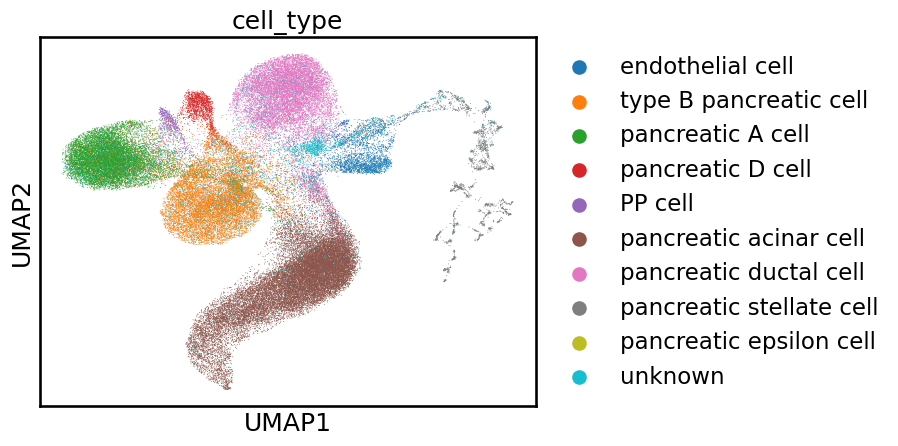

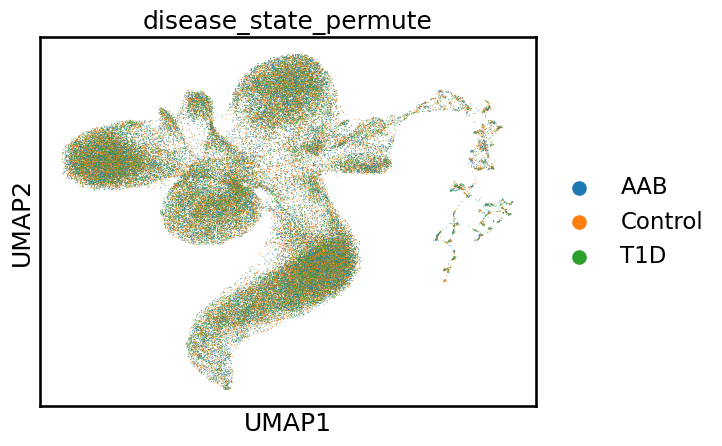

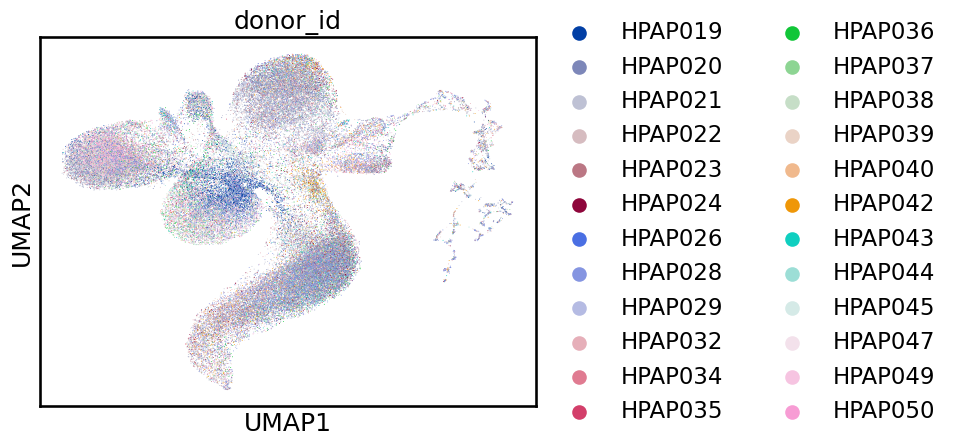

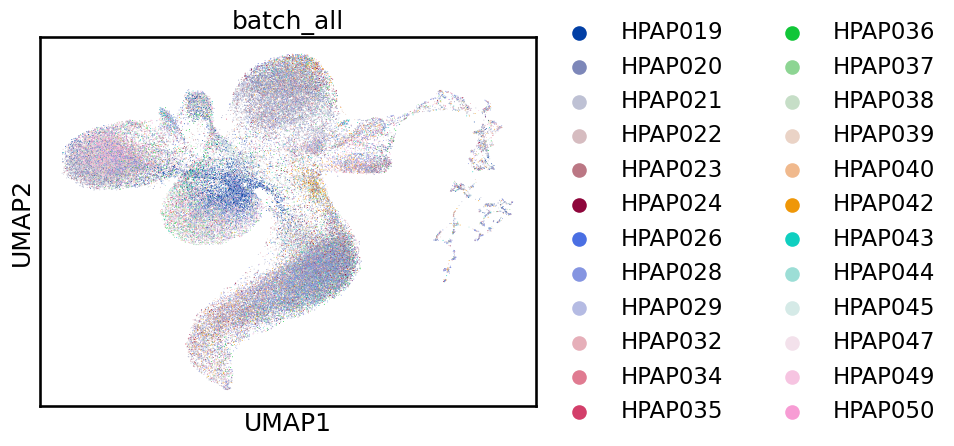

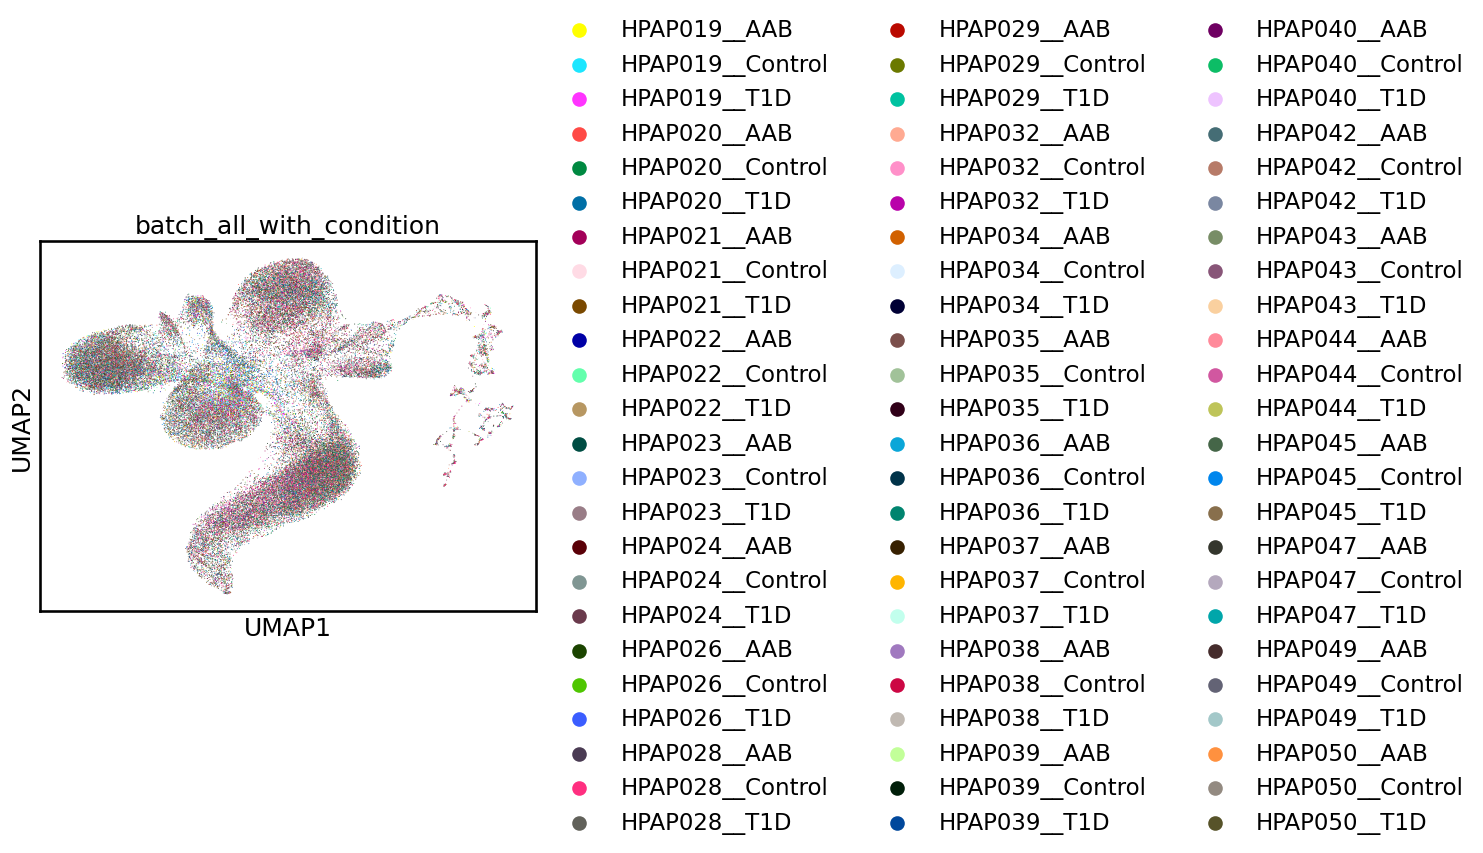

Plot of denoised expression


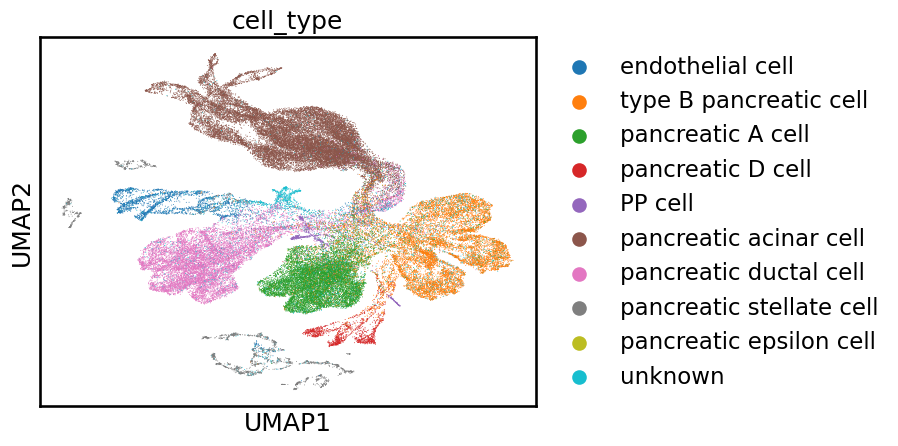

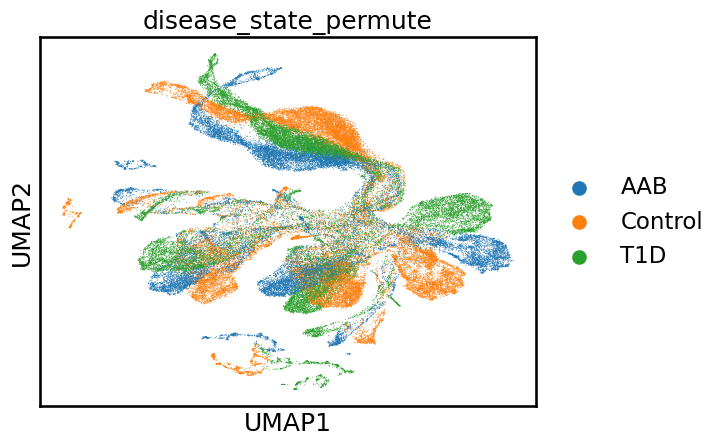

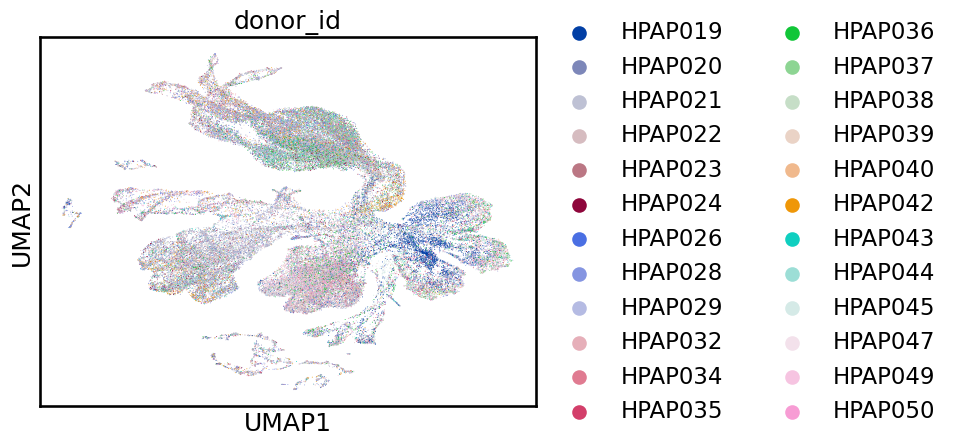

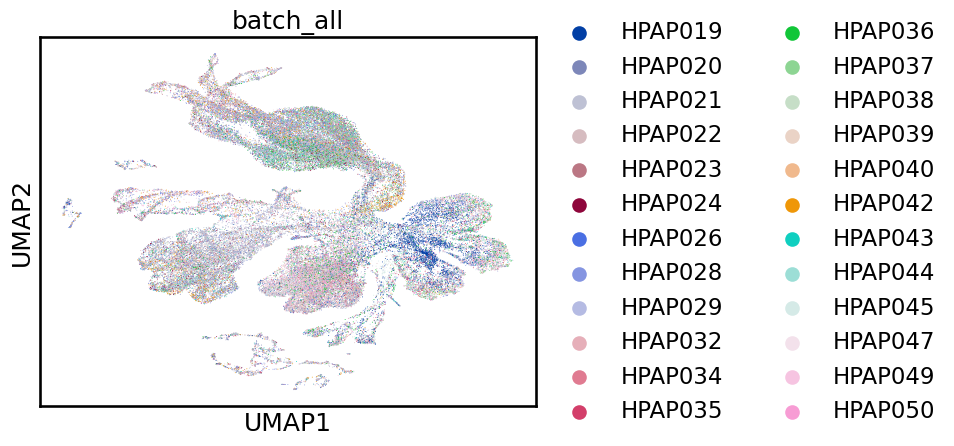

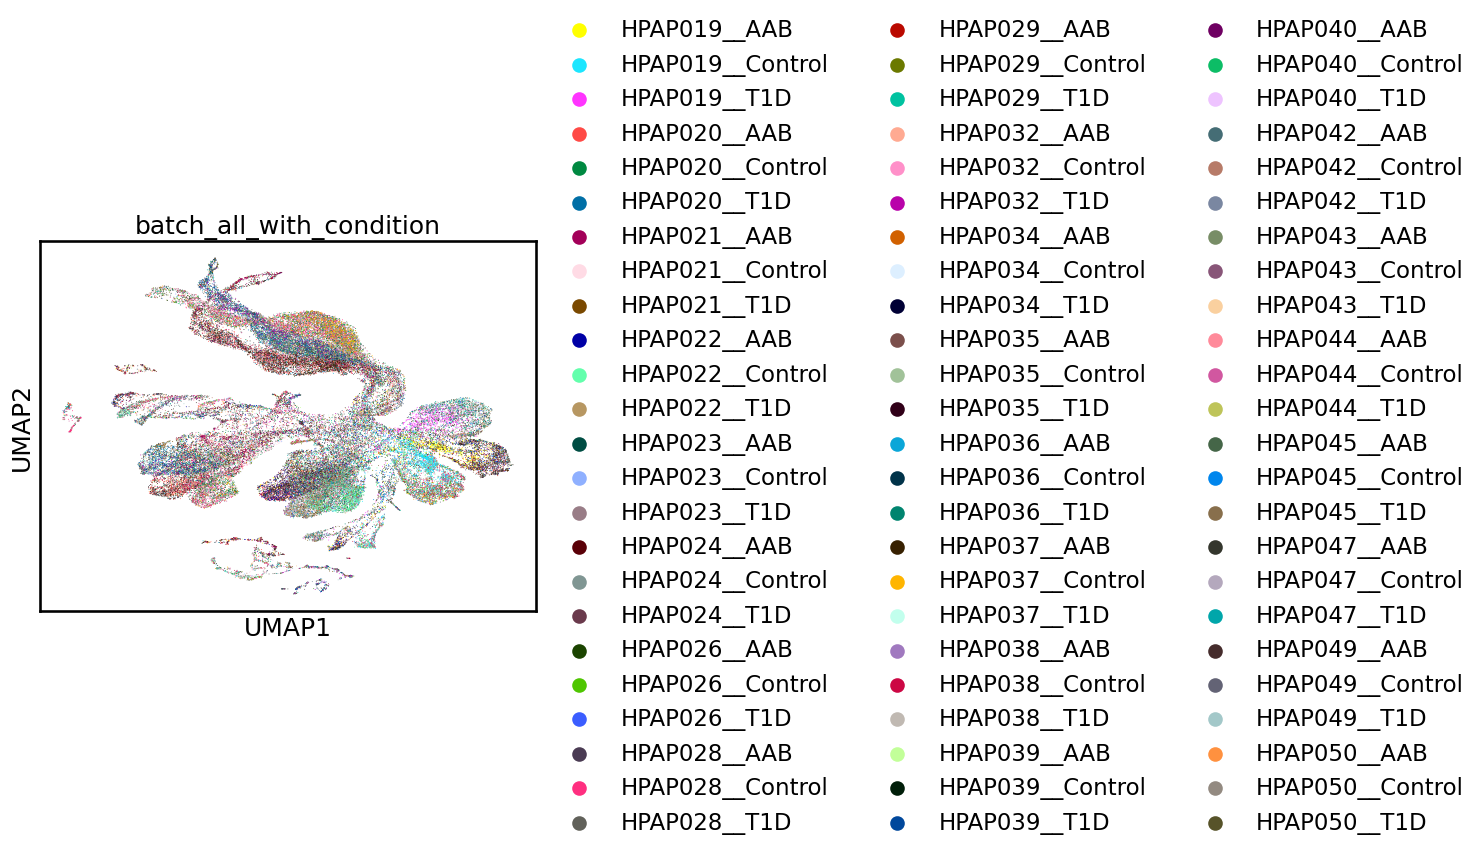

Finish adata preprocessing ====================
Batch effect:
condition-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9672200446678201 0.8034178333576414 0.877742244544852


ASW---


asw_label 0.6907695084810257


asw_batch 0.9847997845054369


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


Adding diffusion to step 15


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


kbet_score 0.8380197267856423


graph_conn 0.8646078252194261


NMI, ARI ---
NMI 0.684086762483481
ARI 0.658683116452205
positive and true positive rate---


       ASW_label       ARI       NMI  1-cLISI     bLISI  ASW_batch  \
X_pca    0.69077  0.658683  0.684087  0.96722  0.803418     0.9848   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca           0.83802            0.864608        0.0  0.866681   

       true pos rate   F1 LISI  
X_pca        0.85999  0.877742  
batch-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9672200446678201 0.18433041977174133 0.30964874289209937


ASW---


asw_label 0.6907695084810257


asw_batch 0.8344584033344262


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


Adding diffusion to step 15


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


kbet_score 0.4514302826014881


graph_conn 0.8646078252194261


NMI, ARI ---
NMI 0.684086762483481
ARI 0.658683116452205
positive and true positive rate---


       ASW_label       ARI       NMI  1-cLISI    bLISI  ASW_batch  \
X_pca    0.69077  0.658683  0.684087  0.96722  0.18433   0.834458   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca           0.45143            0.864608        0.0  0.866681   

       true pos rate   F1 LISI  
X_pca       0.261052  0.309649  
batch-condition-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9672200446678201 0.10860829286062032 0.19528788043132922


ASW---


asw_label 0.6907695084810257


asw_batch 0.7337789971646447


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


kbet_score 0.6305797223683782


graph_conn 0.8646078252194261


NMI, ARI ---
NMI 0.684086762483481
ARI 0.658683116452205
positive and true positive rate---


       ASW_label       ARI       NMI  1-cLISI     bLISI  ASW_batch  \
X_pca    0.69077  0.658683  0.684087  0.96722  0.108608   0.733779   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca           0.63058            0.864608        0.0  0.866681   

       true pos rate   F1 LISI  
X_pca        0.13441  0.195288  
Within each unique condition, evaluate the batch effect of the denoised expression
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating AAB
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9654517456872194 0.19942291191067985 0.3305646614910813


ASW---


asw_label 0.7292765080928802


asw_batch 0.700615590765173


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


kbet_score 0.6296314181717347
graph_conn 0.7834738640354975


NMI, ARI ---
NMI 0.6783649809509682
ARI 0.6307649599128176
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.729277  0.630765  0.678365  0.965452  0.199423   0.700616   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.629631            0.783474        0.0  0.865479   

       true pos rate   F1 LISI  
X_pca        0.33209  0.330565  


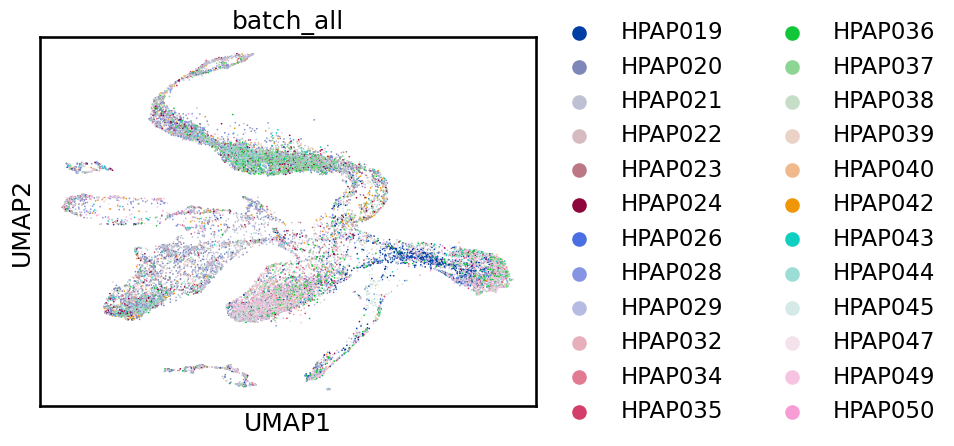

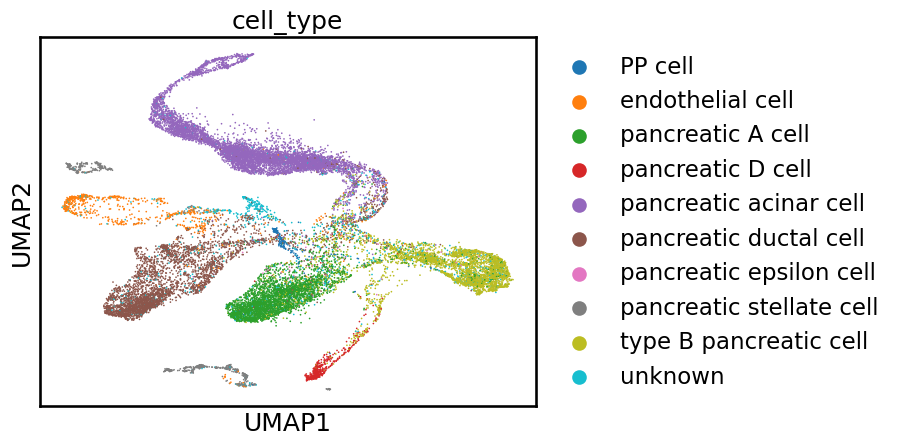

********************
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating Control
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9649647348449797 0.19591402855356402 0.3257017607284775


ASW---


asw_label 0.724851444363594


asw_batch 0.7213822570364309


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


kbet_score 0.6022838892465254
graph_conn 0.7844900961715605


NMI, ARI ---
NMI 0.6941692567092684
ARI 0.7383271607200974
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.724851  0.738327  0.694169  0.964965  0.195914   0.721382   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.602284             0.78449        0.0   0.86339   

       true pos rate   F1 LISI  
X_pca       0.300632  0.325702  


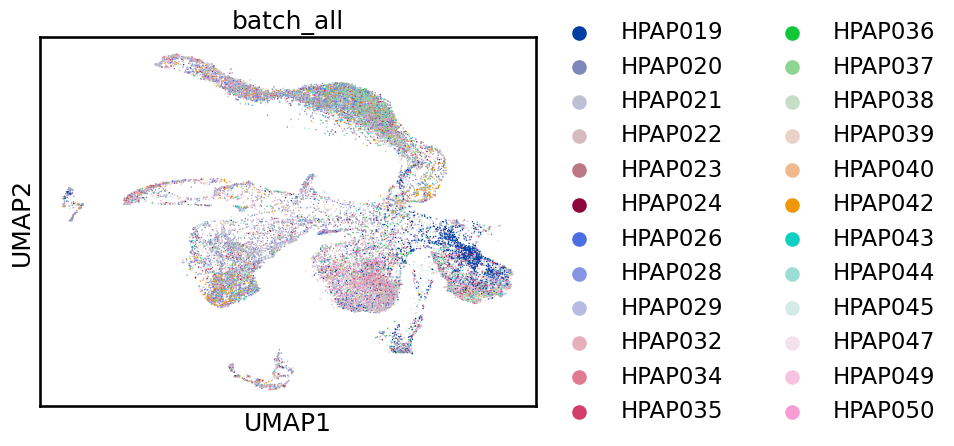

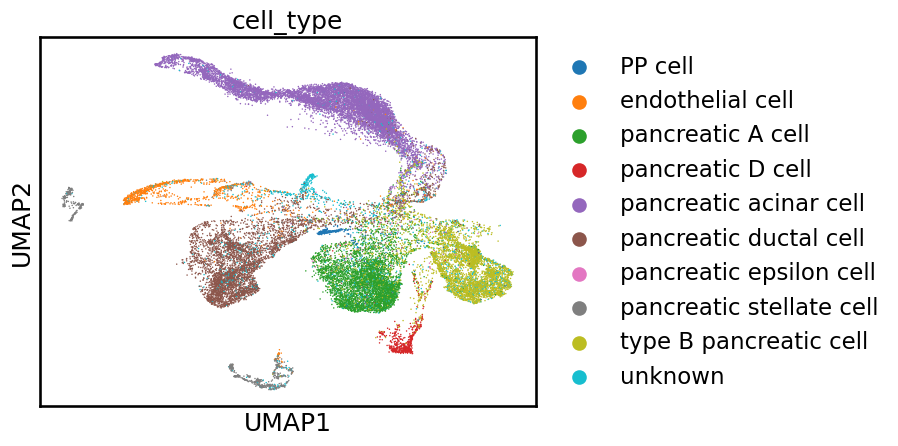

********************
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating T1D
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9646613267718211 0.19810189655644064 0.3287018965411498


ASW---


asw_label 0.7300095856189728


asw_batch 0.6986060120351494


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


kbet_score 0.6355209436479459
graph_conn 0.8264679714957559


NMI, ARI ---
NMI 0.6823773292546412
ARI 0.683750910231378
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca    0.73001  0.683751  0.682377  0.964661  0.198102   0.698606   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.635521            0.826468        0.0   0.86375   

       true pos rate   F1 LISI  
X_pca       0.321205  0.328702  


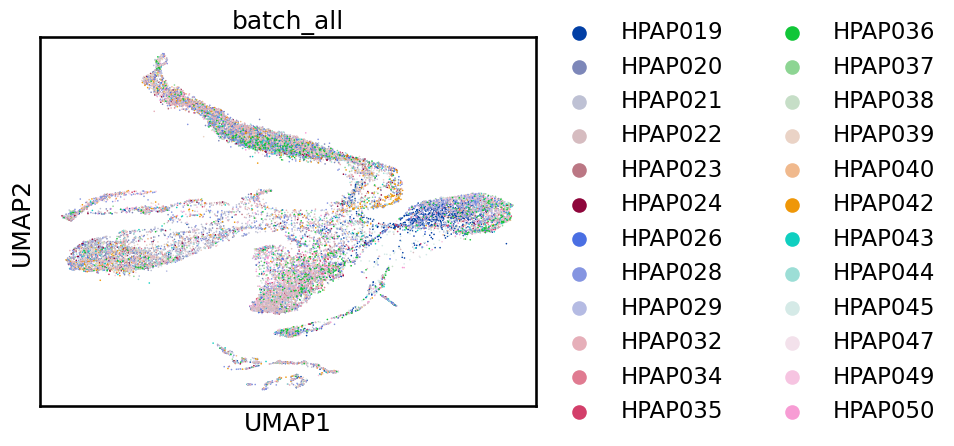

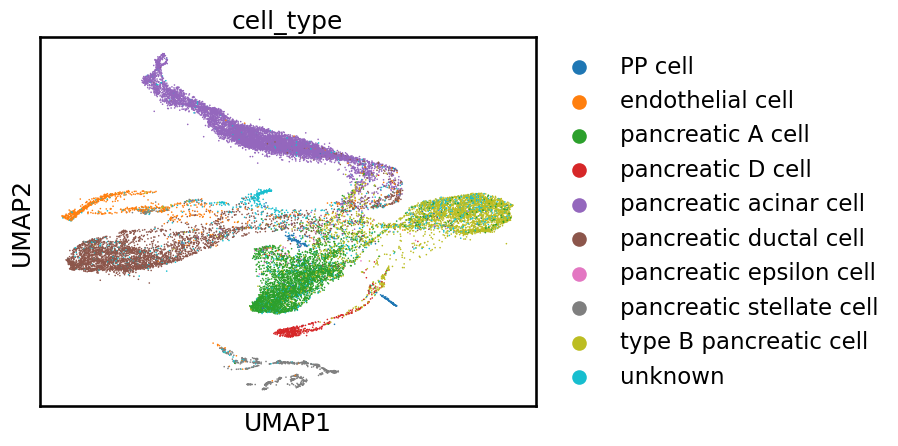

********************
Batch-related mixing performance evaluation for main effect:


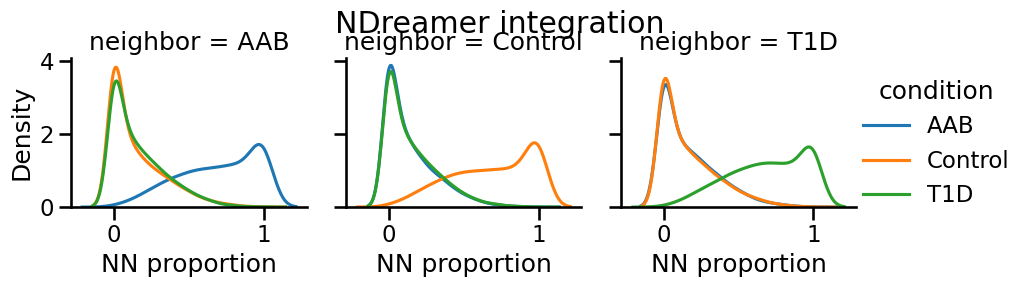

neighbor        AAB   Control       T1D
condition                              
AAB        0.694141  0.141131  0.164727
Control    0.151232  0.686261  0.162507
T1D        0.160099  0.148811  0.691091


In [9]:
i=0
evaluate_ndreamer_batch(dataset_name=dataset_names[i],cell_type_key=cell_type_keys[i],batch_key=batch_keys[i],condition_key=condition_keys[i])